# Salinity budget on the shelf

In [3]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client


In [4]:
client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39051,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:42781,Total threads: 4
Dashboard: /proxy/44939/status,Memory: 35.71 GiB
Nanny: tcp://127.0.0.1:44289,


In [5]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

#session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
session_name ='/g/data/x77/cy8964/databases/basal_melt_MOM5_v2.db'
#session_name = '/g/data/v45/akm157/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

# temperature of meltwater using Gade line:
basal = 'accessom2-GPC015'
iceberg = 'accessom2-GPC018'


In [6]:
expt = basal
session = basal_melt_session

geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)


## Masking shelf

Need to mask just the shelf (<1000m), but parts of shelf have depth > 1000m so can't just do a .where()


use from https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb


In [7]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map


## Plot SWMT Salt component

Code from https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb

In [8]:
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 


In [9]:
start_time = '2150-01-01'
end_time = '2154-12-31'

lat_north = -59

In [10]:
expt = basal
session = basal_melt_session


In [11]:
## getvar all required variables
SST = cc.querying.getvar(expt,'surface_temp',session,frequency='1 monthly') - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
SSS_PSU = cc.querying.getvar(expt,'surface_salt',session,frequency='1 monthly') # SSS - practical salinity (not absolute)
pme_river = cc.querying.getvar(expt,'pme_river',session,frequency='1 monthly') # mass flux of precip - evap + river
# Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005*melt instead
sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly') # mass flux of salt from ice formation/melt
sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly') # mass flux of salt from surface salinity restoring
## getvar the components of the net surface heat fux instead of the net_surface_heating variable
sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,frequency='1 monthly') # W/m2
sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,frequency='1 monthly') # W/m2
sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,frequency='1 monthly') # W/m2
frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,frequency='1 monthly') # W/m2
geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
## slice for time and latitudinal constraints
time_slice = slice(start_time,end_time)
lat_slice = slice(-90,lat_north)
SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
lon_t = geolon_t.sel(yt_ocean=lat_slice)
lat_t = geolat_t.sel(yt_ocean=lat_slice)
## extract coordinate arrays
yt_ocean = SST.yt_ocean.values
xt_ocean = SST.xt_ocean.values
st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
time_monthly = SST.time.values
## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
start_month = int(start_time[5:7])
end_month = int(end_time[5:7])
n_years = int(len(SST.time)/12)
months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
if start_month != 1:
    months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
else:
    months_offset_noleap = months_standard_noleap
days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
## compute net surface heat flux from its component terms
net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
## these are numpy functions, if you have memory errors this is a good step to check (though I have found
## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
depth = -st_ocean[0].values # st_ocean value of the uppermost cell
depth_tile = (lat_t*0+1)*depth
pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
## temperature saved, conversion will be required (make sure you work with C not K)
# SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
# compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
pot_rho_1 = pot_rho_1.load()
# Compute salt transformation (no density binning)
haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
# Note that the salt fluxes have units of (kg of salt)/m^2/s, while beta has
# units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
# the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
# to be multiplied by SSS to convert to (g of salt)/m^2/s
# This gives units of (kg of water)/m² for the salt_transformation but it
# will later be divided by time and density and be in m/s:
salt_transformation = haline_contraction*(SSS*pme_river-(sfc_salt_flux_ice + sfc_salt_flux_restore)*1000)*days_per_month #! before was PSU, why?
salt_transformation = salt_transformation.load()


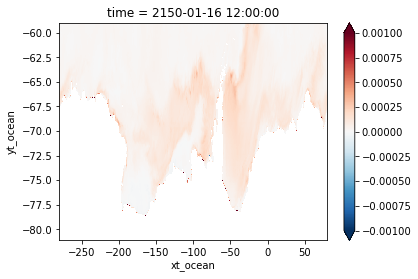

In [12]:
salt_transformation.isel(time = 0).plot(vmax = 0.001)

In [13]:
### Since basal and iceberg are 3D fields, need to compute beta coefficient for conversion between salt to FW 
### at 3D fields, not just at surface. Unfortunately this slows down computation even more. 


# def get_salt_budget_terms_3D(expt, session, start_time, end_time, lat_north = -59):
#     '''
#     Gets surface water-mass transformation rates, copied from cosima recipes
#     https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb
#     '''
#     ## getvar all required variables
#     SST = cc.querying.getvar(expt,'temp',session,frequency='1 monthly',start_time=start_time,end_time=end_time) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
#     SSS_PSU = cc.querying.getvar(expt,'salt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # SSS - practical salinity (not absolute)
#     pme_river = cc.querying.getvar(expt,'pme_river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of precip - evap + river
#     melt = cc.querying.getvar(expt,'melt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
#     river = cc.querying.getvar(expt,'river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
#     # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005*melt instead
#     sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
#     sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring

#     varlist = cc.querying.get_variables(session, expt)
#     if varlist['name'].str.contains('salt_basalmix').any():
#         salt_basalmix = cc.querying.getvar(expt,'salt_basalmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
#     else:
#         salt_basalmix = xr.zeros_like(sfc_salt_flux_ice)
        
#     if varlist['name'].str.contains('salt_icbmix').any():
#         salt_icbmix = cc.querying.getvar(expt,'salt_icbmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
#     else:
#         salt_icbmix = xr.zeros_like(sfc_salt_flux_ice)
        
#     ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
#     #sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,frequency='1 monthly') # W/m2
#     #sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,frequency='1 monthly') # W/m2
#     #sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,frequency='1 monthly') # W/m2
#     #frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,frequency='1 monthly') # W/m2
#     geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
#     geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
#     ## slice for time and latitudinal constraints
#     time_slice = slice(start_time,end_time)
#     lat_slice = slice(-90,lat_north)
#     SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
#     SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
#     pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
#     melt = melt.sel(time=time_slice, yt_ocean=lat_slice)
#     river = river.sel(time=time_slice, yt_ocean=lat_slice)
#     sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
#     sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
#     salt_basalmix = salt_basalmix.sel(time=time_slice, yt_ocean=lat_slice)
#     salt_icbmix = salt_icbmix.sel(time=time_slice, yt_ocean=lat_slice)
    
#     #sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
#     #sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
#     #sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
#     #frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
#     lon_t = geolon_t.sel(yt_ocean=lat_slice)
#     lat_t = geolat_t.sel(yt_ocean=lat_slice)
#     ## extract coordinate arrays
#     yt_ocean = SSS_PSU.yt_ocean.values
#     xt_ocean = SSS_PSU.xt_ocean.values
#     st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
#     time_monthly = SSS_PSU.time.values
#     ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
#     start_month = int(start_time[5:7])
#     end_month = int(end_time[5:7])
#     n_years = int(len(SSS_PSU.time)/12)
#     months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
#     if start_month != 1:
#         months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
#     else:
#         months_offset_noleap = months_standard_noleap
#     days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
#     ## compute net surface heat flux from its component terms
#     #net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
#     ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
#     ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
#     ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
#     depth = -st_ocean # st_ocean value of the uppermost cell
#     depth_tile = (SST.isel(time = 0)*0+1)*depth
#     lat_t = (SST.isel(time = 0)*0+1)*lat_t
#     lon_t = (SST.isel(time = 0)*0+1)*lon_t
    
#     pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [st_ocean,yt_ocean, xt_ocean], dims = ['st_ocean','yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
#     # convert units to absolute salinity 
#     SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly,st_ocean, yt_ocean, xt_ocean], dims = ['time','st_ocean','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
#     ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
#     ## temperature saved, conversion will be required (make sure you work with C not K)
#     # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
#     # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
#     #pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
#     #pot_rho_1 = pot_rho_1.load()
#     # Compute salt transformation (no density binning)
#     haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, st_ocean, yt_ocean, xt_ocean], dims = ['time','st_ocean','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
#     # Note that the salt fluxes have units of (kg of salt)/m^2/s, while beta has
#     # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
#     # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
#     # to be multiplied by SSS to convert to (g of salt)/m^2/s
#     # This gives units of (kg of water)/m² for the salt_transformation but it
#     # will later be divided by time and density and be in m/s:
#     #salt_transformation = haline_contraction*(SSS*pme_river-(sfc_salt_flux_ice + sfc_salt_flux_restore + salt_basalmix + salt_icbmix)*1000)*days_per_month #! before was PSU, why?
#     #salt_transformation = salt_transformation.load()
    
#     haline_contraction = haline_contraction.load()
    
#     pme_river_salt_trans = haline_contraction.isel(st_ocean = 0)*SSS.isel(st_ocean = 0)*pme_river*days_per_month
#     pme_river_salt_trans = pme_river_salt_trans.load()

#     river = haline_contraction.isel(st_ocean = 0)*SSS.isel(st_ocean = 0)*river*days_per_month
#     river = river.load()

#     melt = haline_contraction.isel(st_ocean = 0)*SSS.isel(st_ocean = 0)*melt*days_per_month
#     melt = melt.load()
    
#     ice = haline_contraction.isel(st_ocean = 0)*sfc_salt_flux_ice*1000*days_per_month
#     ice = ice.load()
    
#     restore = haline_contraction.isel(st_ocean = 0)*sfc_salt_flux_restore*1000*days_per_month
#     restore = restore.load()
    
#     basal = haline_contraction*salt_basalmix*1000*days_per_month
#     basal = basal.load()
    
#     icb = haline_contraction*salt_icbmix*1000*days_per_month
#     icb = icb.load()
    
    
    
#     return pme_river_salt_trans, river, melt, ice, restore, basal, icb, days_per_month


In [14]:
### This uses 2D beta as I haven't gotten 3D beta to compute

def get_salt_budget_terms(expt, session, start_time, end_time, lat_north = -59):
    '''
    Gets surface water-mass transformation rates, copied from cosima recipes
    https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb
    and modified to add melt, river, basalmix and icbmix and output these FW fluxes
    '''
    ## getvar all required variables
    SST = cc.querying.getvar(expt,'surface_temp',session,frequency='1 monthly',start_time=start_time,end_time=end_time) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    SSS_PSU = cc.querying.getvar(expt,'surface_salt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # SSS - practical salinity (not absolute)
    pme_river = cc.querying.getvar(expt,'pme_river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of precip - evap + river
    melt = cc.querying.getvar(expt,'melt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
    river = cc.querying.getvar(expt,'river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
    # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005*melt instead
    sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
    sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring

    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('salt_basalmix').any():
        salt_basalmix = cc.querying.getvar(expt,'salt_basalmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
    else:
        salt_basalmix = xr.zeros_like(sfc_salt_flux_ice)
        
    if varlist['name'].str.contains('salt_icbmix').any():
        salt_icbmix = cc.querying.getvar(expt,'salt_icbmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
    else:
        salt_icbmix = xr.zeros_like(sfc_salt_flux_ice)
        
    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    #sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,frequency='1 monthly') # W/m2
    #sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,frequency='1 monthly') # W/m2
    #sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,frequency='1 monthly') # W/m2
    #frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,frequency='1 monthly') # W/m2
    geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
    geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time,end_time)
    lat_slice = slice(-90,lat_north)
    SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
    melt = melt.sel(time=time_slice, yt_ocean=lat_slice)
    river = river.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
    salt_basalmix = salt_basalmix.sel(time=time_slice, yt_ocean=lat_slice)
    salt_icbmix = salt_icbmix.sel(time=time_slice, yt_ocean=lat_slice)
    
    #sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
    #sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    #sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
    #frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
    lon_t = geolon_t.sel(yt_ocean=lat_slice)
    lat_t = geolat_t.sel(yt_ocean=lat_slice)
    ## extract coordinate arrays
    yt_ocean = SSS_PSU.yt_ocean.values
    xt_ocean = SSS_PSU.xt_ocean.values
    st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
    time_monthly = SSS_PSU.time.values
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SSS_PSU.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap
    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
    ## compute net surface heat flux from its component terms
    #net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -st_ocean[0].values # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0+1)*depth
    pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    #pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    #pot_rho_1 = pot_rho_1.load()
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
    # Note that the salt fluxes have units of (kg of salt)/m^2/s, while beta has
    # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
    # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
    # to be multiplied by SSS to convert to (g of salt)/m^2/s
    # This gives units of (kg of water)/m² for the salt_transformation but it
    # will later be divided by time and density and be in m/s:
    #salt_transformation = haline_contraction*(SSS*pme_river-(sfc_salt_flux_ice + sfc_salt_flux_restore + salt_basalmix + salt_icbmix)*1000)*days_per_month #! before was PSU, why?
    #salt_transformation = salt_transformation.load()
    
    haline_contraction = haline_contraction.load()
    
    pme_river_salt_trans = haline_contraction*SSS*pme_river*days_per_month
    pme_river_salt_trans = pme_river_salt_trans.load()

    river = haline_contraction*SSS*river*days_per_month
    river = river.load()

    melt = haline_contraction*SSS*melt*days_per_month
    melt = melt.load()
    
    ice = haline_contraction*sfc_salt_flux_ice*1000*days_per_month
    ice = ice.load()
    
    restore = haline_contraction*sfc_salt_flux_restore*1000*days_per_month
    restore = restore.load()
    
    basal = haline_contraction*salt_basalmix*1000*days_per_month
    basal = basal.load()
    
    icb = haline_contraction*salt_icbmix*1000*days_per_month
    icb = icb.load()
    
    
    
    return pme_river_salt_trans, river, melt, ice, restore, basal, icb, days_per_month


0


Text(0.5, 1.0, 'Global freshwater budget (kg/s)')

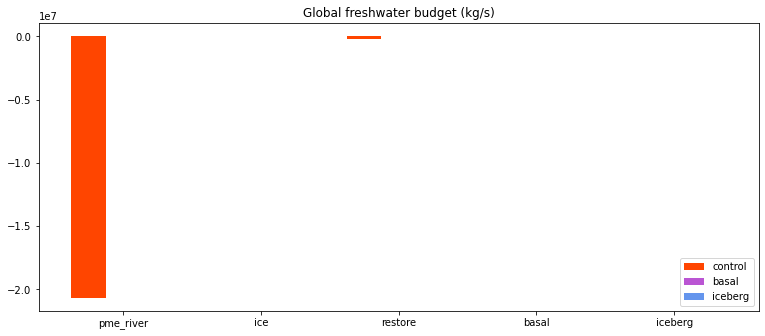

In [15]:
## Global integral (USING 2D BETA)

start_time = '2155-01-01'
end_time = '2155-12-31'
session = master_session
expt = control
lat_north = 90
area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean = slice(-90,lat_north))

bar_plot = np.zeros((3,5))

for i in np.arange(1): # JUST CONTROL EXPT
    print(i)
    expt = [control,basal,iceberg][i]
    session = [master_session,basal_melt_session,basal_melt_session][i]
    
    pme_river_salt_trans,river,melt,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)
    ndays = days_per_month.sum().values
    bar_plot[i,:]=[#(salt_transformation*area_t).sum()/ndays,
                   (pme_river_salt_trans*area_t).sum()/ndays,
                   -(ice*area_t).sum()/ndays,
                   -(restore*area_t).sum()/ndays,
                   -(basalh*area_t).sum()/ndays,
                   -(icb*area_t).sum()/ndays                   
                  ]

X = np.arange(5)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','ice','restore','basal','iceberg'))
plt.title('Global freshwater budget (kg/s)')


In [16]:
bar_plot

array([[-20661577.78960356,     27222.04987717,   -225273.10836503,
               -0.        ,        -0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ,         0.        ]])

In [17]:
20661577/225273.10836503

91.71790254929236

pme_river is 90 times bigger than restoring term, and same sign. Something wrong as these should approximately cancel each other in the global integral.

## Shelf with 2D beta

0
1


2023-03-20 10:56:13,638 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 25.01 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 10:56:18,298 - distributed.worker_memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 30.11 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 10:56:18,809 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 31.46 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 10:56:19,857 - distributed.worker_memory - WARNING - Worker is at 52% memory usage. Resuming worker. Proces

2


2023-03-20 11:02:33,998 - distributed.worker_memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 29.85 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:02:35,337 - distributed.worker_memory - WARNING - Worker is at 70% memory usage. Resuming worker. Process memory: 25.01 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:03:09,317 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 28.47 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:03:50,634 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

[[-3364270.42769183  2228459.63021731  -662283.89580569   883195.93466024
     64796.96641643       -0.               -0.        ]
 [-5353612.24509377  1096414.30585566  -866542.17067688  1007953.26329434
    -25959.09682105  1221562.63287644       -0.        ]
 [-6902545.59290851        0.         -1058700.67550349  1076736.30261142
   -177034.33657965  1222458.19963593   630850.24206127]]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (7,).

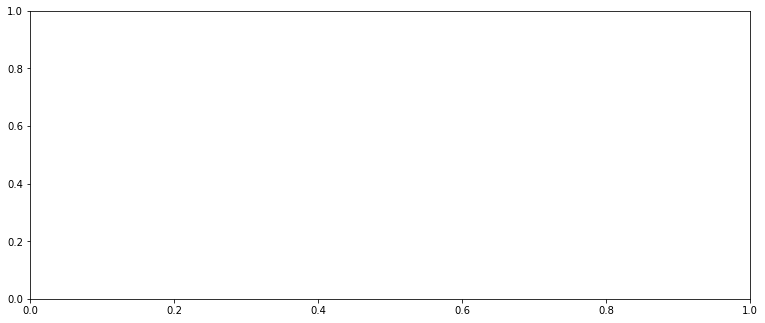

In [17]:
## Shelf

start_time = '2155-01-01'
end_time = '2155-12-31'
lat_north = -59
session = master_session
expt = control
area_t = cc.querying.getvar(expt, 'area_t', session, n = 1).sel(yt_ocean = slice(-90,lat_north))

bar_plot = np.zeros((3,7))

for i in np.arange(3):
    print(i)
    expt = [control,basal,iceberg][i]
    session = [master_session,basal_melt_session,basal_melt_session][i]
    
    pme_river_salt_trans,river,melt,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)
    ndays = days_per_month.sum().values
    pme_river_salt_trans_shelf, shelf_mask = shelf_mask_isobath(pme_river_salt_trans)
    ice_shelf, shelf_mask = shelf_mask_isobath(ice)
    restore_shelf, shelf_mask = shelf_mask_isobath(restore)
    basal_shelf, shelf_mask = shelf_mask_isobath(basalh)
    icb_shelf, shelf_mask = shelf_mask_isobath(icb)
    
    
    bar_plot[i,:]=[#(salt_transformation_shelf*area_t).sum()/ndays,
                   (pme_river_salt_trans_shelf*area_t).sum()/ndays,
                   (river*area_t).sum()/ndays,
                   (melt*area_t).sum()/ndays,        
                   -(ice_shelf*area_t).sum()/ndays,
                   -(restore_shelf*area_t).sum()/ndays,
                   -(basal_shelf*area_t).sum()/ndays,
                   -(icb_shelf*area_t).sum()/ndays
                  ]
print(bar_plot)
X = np.arange(7)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','ice','restore','basal','iceberg'))
plt.title('Antarctic shelf freshwater budget (kg/s)')


In [21]:
## data from above computation
bar_plot

array([[-3364270.42769183,  2228459.63021731,  -662283.89580569,
          883195.93466024,    64796.96641643,       -0.        ,
              -0.        ],
       [-5353612.24509377,  1096414.30585566,  -866542.17067688,
         1007953.26329434,   -25959.09682105,  1221562.63287644,
              -0.        ],
       [-6902545.59290851,        0.        , -1058700.67550349,
         1076736.30261142,  -177034.33657965,  1222458.19963593,
          630850.24206127]])

Text(0.5, 1.0, 'Antarctic shelf freshwater budget (kg/s)')

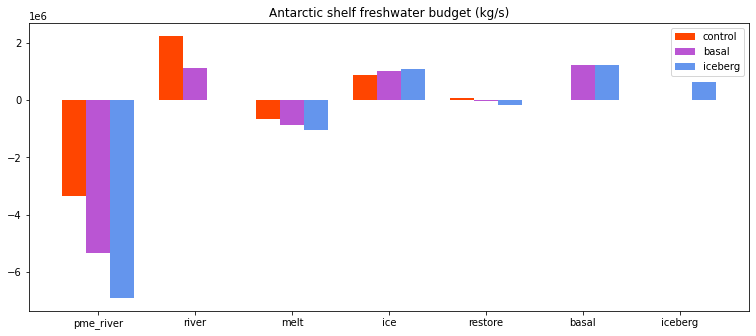

In [18]:
X = np.arange(7)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','river','melt','ice','restore','basal','iceberg'))
plt.title('Antarctic shelf freshwater budget (kg/s)')


Alternative groupings

In [22]:
bar_plot_copy = np.zeros((3,8))
bar_plot_copy[:,0] = bar_plot[:,0]-bar_plot[:,1]-bar_plot[:,2] #pme_river - melt - river
bar_plot_copy[:,1] = bar_plot[:,1]#river
bar_plot_copy[:,2] = bar_plot[:,2]#melt
bar_plot_copy[:,3] = bar_plot[:,3]#ice
bar_plot_copy[:,4] = bar_plot[:,4]#restore
bar_plot_copy[:,5] = bar_plot[:,5]#basal
bar_plot_copy[:,6] = bar_plot[:,6]#iceberg
bar_plot_copy[:,7] = bar_plot[:,0]+bar_plot[:,3]+bar_plot[:,4]+bar_plot[:,5]+bar_plot[:,6]#total


Text(0.5, 1.0, 'Antarctic shelf freshwater budget (kg/s)')

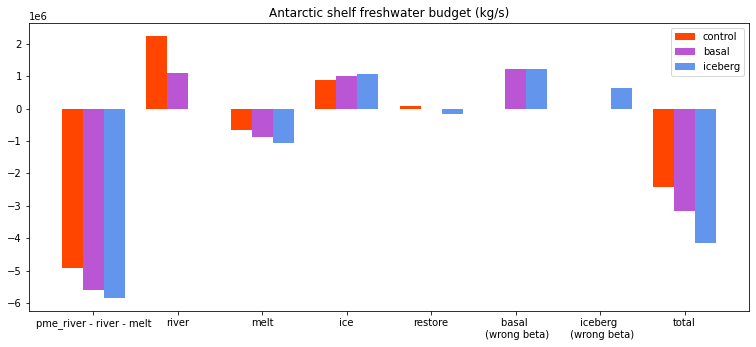

In [24]:
X = np.arange(8)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot_copy[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot_copy[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot_copy[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river - river - melt','river','melt','ice','restore','basal \n (wrong beta)','iceberg \n (wrong beta)','total'))
plt.title('Antarctic shelf freshwater budget (kg/s)')


Suggests net salinification on shelf. But my salt change analysis suggests net freshening. Something wrong.